# Going deeper with Tensorflow

In this video, we're going to study the tools you'll use to build deep learning models. Namely, [Tensorflow](https://www.tensorflow.org/).

If you're running this notebook outside the course environment, you'll need to install tensorflow:
* `pip install tensorflow` should install cpu-only TF on Linux & Mac OS
* If you want GPU support from offset, see [TF install page](https://www.tensorflow.org/install/)

In [1]:
import sys
sys.path.append("..")
import grading

# Visualization

Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there. If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [2]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

In [3]:
import tensorflow as tf
s = tf.InteractiveSession()

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [4]:
import numpy as np
def sum_sin(N):
    return np.sum(np.arange(N)**2)

In [5]:
%%time
sum_sin(10**8)

CPU times: user 249 ms, sys: 283 ms, total: 532 ms
Wall time: 531 ms


662921401752298880

# Tensoflow teaser

Doing the very same thing

In [6]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [7]:
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [8]:
%%time
result.eval({N: 10**8})

CPU times: user 346 ms, sys: 213 ms, total: 559 ms
Wall time: 422 ms


662921401752298880

In [9]:
writer = tf.summary.FileWriter("/tmp/tboard", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder:value})`
  * `s.run(output, {placeholder:value})`

So far there are two main entities: "placeholder" and "transformation"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If if you can't find the op you need, see the [docs](https://www.tensorflow.org/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [10]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [11]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [12]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [13]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector:dummy, my_vector2:dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [14]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* The graphs consist of placehlders and transformations

# Mean squared error

Your assignment is to implement mean squared error in tensorflow.

In [15]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")

    mse = tf.reduce_mean(tf.square(y_true - y_predicted))
    
def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [16]:
writer.add_graph(mse.graph)
writer.flush()

Tests and result submission. Please use the credentials obtained from the Coursera assignment page.

In [17]:
import submit

In [18]:
submit.submit_mse(compute_mse, "", "")

Submitted to Coursera platform. See results on assignment page!


# Variables

The inputs and transformations have no value outside function call. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [19]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [20]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating shared variable (outside symbolicd graph)
print("Initial value", s.run(shared_vector_1))

# Within symbolic graph you use them just
# as any other inout or transformation, not "get value" needed

Initial value [1. 1. 1. 1. 1.]


In [21]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [22]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [23]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

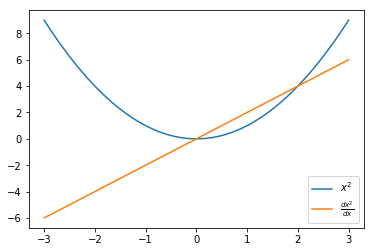

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [25]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

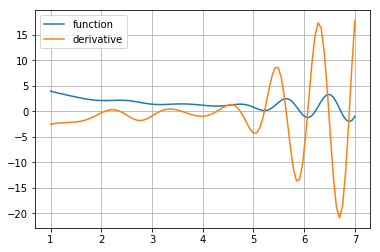

In [26]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [27]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')
loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 
#loss = tf.reduce_mean((y_guess - y_true)**2) 
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss, var_list=y_guess)

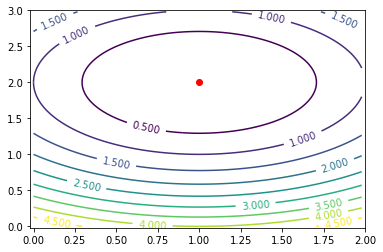

In [28]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

guesses = [s.run(y_guess)]

def animate(i):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    line.set_data(*zip(*guesses))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)

In [29]:
try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except RuntimeError:
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACzu21kYXQAAAKtBgX//6ncRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTM4IHIyMCA0MGU3MmRhIC0gSC4yNjQvTVBFRy00IEFW
QyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gy
NjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4
MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0x
IG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9u
ZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2th
aGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNl
ZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFt
aWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2Vp
Z2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNo
PTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFw
bWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAMsFliIQA
L//+9q78yytHC5UuHVl7s1Hy6Ely/YgwfWgAAAMAANVrIXyhglVQGODkKXxQL3nTCdA5ubEukxJ5
N3Y3Wjtm9TudkuqJ1Baz0hGofipkW5Q06+CuAACsYHtaUROWg978k/hP1xiZbxc5x5rY8190B8N9
3ojP8sM0pCbJPhS2rIz1Wlngpbi4oxw00/Y3BNHzbik+J304aUl67LfJq94hfpNhomGLf4bGxSWB
t0PvCLpYnyplKLQ9pKfazgWFwD9cF6Gdx9dFNPOfCmpTp4rIV164dzLxlK4c5vvosBl8j0IuqiKu
GoCdjHVCY1R0piA3YaGnn1tnUXvk4RXiGwlZsPgxU9r13EaBmfIgKA12u8/NePKIMQn+wtQDSKiM
S+ev3IAAS2qm/R7r+GHIeUKlTXSZMxteZ9GPxtgbLbpZ+ZZ+eP9iWmfcTL6ZV99addoJ3b2rTD/E
PmiKqzvKwTPESlDOo26Q1p8Kw6lFozKByi0rW2820FDVoq/bQW9PT9NyWQrvZqioHs8smOY1FsSB
NH2mYsBQ/1FEFtM92li2nzINMSBbTirJslqDaapKh7LKkaRZfX28eOKO2sCDc2iCmJHRmO8xCRJJ
9jC/qA/ef0mFmcu3HTg0qiSg+Ig9iycWJcMSXCJfemDrlfhfU8RC0qC9r29kOeRll0p4i3ypi6FG
H6sdzqSTc053jGG9l+wNDgzOQ+KN+BHqV8l9t/9R2k0uylltJR9oNnaSxMbxfDK0M9yWtfh/MPEP
nbYOFEeNfnwNiw/EAMUPteUJLjtr/pvPAI/wziL6VfuwCHsg9AhO8vc7jfs9vm/fwXclJ1CO5AP5
PtrEXMAt6EfZ1SDMK76smEWOoA1FttwfjuoSEQ863fVByAlP0TBdwYdDLzzKaVX16nypCf78kg1P
rWl2ecoudPE+LfH51pgGQ4yI3oDjvycln5tIgv4SMqkNWHKlhAcqBm7sNq4YkY52U1L5pVfrfR9G
JnfKx/nuaOlhli1DcETU4w0xTfHZ2muDD3nWGzKrttl8zQp5LZdG0MP1TqEssqIV7zouhn6akNv0
KprcpnTFqpsPSMcw6Zr/wftPybpIl8JQsW88W7/jv+lXWWZ7OVWDV4XVz6ECGxqeFg5j0sE8nEDe
GtrrFrJ5vl4V9NeelvE08jEI/IuJB10s2CLLxYcbKvluHAPUeIMIoF/1zEthsuxYETBVOlVLhRn9
7JZuhrLIjOCTR7OYimpMbuIf/3UwNQQQ0WxGHaFnyhN+MQJ/xCxs1ZvE70OVuk2KxJavyOW5JoSP
o9nkmfDMmS8xSrMpUmpzSP8AEAv3SgB128Vxp5Gft5erVAN6H6Asv2YiA/48SdbZK8onfUQttFge
oVB8Fn+88ft7fZa1r2L90UBFFWlNOBMBYqMfZhG7wQhT7t8ykdKgeW34NOxKWMBm9KM67wInxBJN
y/7tiVd49gGebtttjeKKWvihsJWaspewxzGkJh+QEFrVq6UOd0FuQE0Ve4dSA26FbdUGmReh8pc1
J2vbTTvUwZq/rM9XnIjUSR24SyY1UwwW2wUQ/9VdUPw/cBPzoKT0ALvbBpGtv6foZFYNblaTshh5
b+7yk36gNwnIthTVNOvDKXBIMPZe82hkHNOXiKYXrRJxoTw5Q2PU/X8x8UY+NAOU8X5iMptOLSVr
/8Wy75IyLah4gDRnpRChI3UH0sAAE0Zbi122CGHqbayEBVnuwq8cdjSEu6pNbjdHyHDIyg0IHGWU
EMtvxEzavP2XlIWi12KKwv/LIDe+IHM+YZevmxUGfu6M34Gyfkf4RAxg4Uey2NLmt71y09QWBSBS
tYSZk/fvjCjo3arOt1CkpA/JFNT/u9jYSlPAPe/xLHnyN8NN4Iwbp4JanuEZFb4s9PI2y6I3Qisp
2W/RZXaDEXojrJR1VVeW8QLshlwAESk8UkkI2vVYsFqLhwXZoQhT8RgKtz1bQ76i6LxBO62raM2P
0/+45PBRDljAVMUdXl/H2ZIJJx7R2IcRzP9vLswzoJ5dt4+mdhoRH+WFVGDqA/I/H1+liA+OBvnj
ZTvECP6oD+jt8YxvJlA+0lQ1B8ua1nYEoCB/CgjcWOoKmPrJjJ/+ZdKuOZm/aCMgElGbO51xmbM7
liORN+/sv2J1kHbYnyKEwKOUkuSvsAr30YvLnMUTNXX59VkOo3dy+ee3f4tZ9p79eAwW8ZymLwhu
I72OMki19cDppMXgU21AKCx6iFIovZrWUJFySBPdmbn/MBbFKyrZbC1aXWKnSm0YhRbb93eQHpg8
LV53eLOmwP9s0CoU44F8YrjCdr1oFxNjocmfmLg0QSbn1dvjYNmZDS/zrmNWSgn1yeRRuqwz8sZm
xLAcHbySAsbqbPTd/Yd+A4DireRyqVu3MEpPpewsxtVIw66P0hYAnZzwYdjLgbAC4Sv0t1pm+Md6
XLaDrkCbDfnMAo4LQfba1oHQZ45ahn7Dw5wbzmf6aoa7z3HY0AW3eeetY+/RTAmOLfT/+cd5Gi5l
+pOrGwybqo9OVanSiU5ScTh4K0izUKEbjXkQhoxghN8mblgQJH7C63mQLVDP1l4uoY/rgentAbHG
aG6+Azm8k2hrTqGofIGpTRBEg3JEJAYDaqFbu6fPRqSckt+8drcNkKMGb8SwkglXtwdIJMpHnQ2a
zg14mmTO73uXLem6VNyOqQx9i4oqb5pugid+j+M6skKY4QzJFl33cv3g6DVdyFEjyO20YSRUfIUL
fdBdg2IM2ucPPRh+5fjomCGMj4Suz8KaXy5gR/LK6XyTRtnL+0Ns06Hro6mDo2R0jp3jKAyjCuYZ
ORdJdXz6OI8QGruLhOyooghoggllMMW3C3YIERXVN7CwSKET69OPo2JO02S3ynZEBFtvBsxCTacv
V3PgydoHcx6+pYZt9I34D

# Logistic regression
Your assignment is to implement the logistic regression

Plan:
* Use a shared variable for weights
* Use a matrix placeholder for `X`
 
We shall train on a two-class MNIST dataset
* please note that target `y` are `{0,1}` and not `{-1,1}` as in some formulae

In [30]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:


X:
 [[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.]
 [ 0.  0.  1.  9. 15. 11.  0.  0.  0.  0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


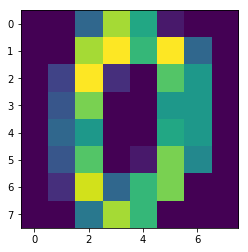

In [31]:
print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[0].reshape([8,8]));

It's your turn now!
Just a small reminder of the relevant math:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

__Your code goes here.__ For the training and testing scaffolding to work, please stick to the names in comments.

In [33]:
# Model parameters - weights and bias
# weights = tf.Variable(...) shape should be (X.shape[1], 1)
# b = tf.Variable(...)
weights = tf.Variable(tf.zeros((X.shape[1], 1)), dtype=tf.float32)
b = tf.Variable(0, dtype=tf.float32)

In [34]:
# Placeholders for the input data
# input_X = tf.placeholder(...)
# input_y = tf.placeholder(...)
input_X = tf.placeholder(tf.float32, (None, X.shape[1]))
input_y = tf.placeholder(tf.float32, (None,))

In [35]:
# The model code

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can get rid of them with tf.squeeze .
# Don't forget the sigmoid.
predicted_y = tf.nn.sigmoid(tf.matmul(input_X, weights) + b)
predicted_y = tf.squeeze(predicted_y)

# Loss. Should be a scalar number - average loss over all the objects
# tf.reduce_mean is your friend here
loss = -tf.reduce_mean(input_y * tf.log(predicted_y) + (1. - input_y) * tf.log(1. - predicted_y))

# See above for an example. tf.train.*Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)

A test to help with the debugging

In [36]:
validation_weights = 1e-3 * np.fromiter(map(lambda x:
        s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 0.1, 2]}),
                                   0.15 * np.arange(1, X.shape[1] + 1)),
                                   count=X.shape[1], dtype=np.float32)[:, np.newaxis]
# Compute predictions for given weights and bias
prediction_validation = s.run(
    predicted_y, {
    input_X: X,
    weights: validation_weights,
    b: 1e-1})

# Load the reference values for the predictions
validation_true_values = np.loadtxt("validation_predictons.txt")

assert prediction_validation.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in input_X"
assert np.allclose(validation_true_values, prediction_validation)
loss_validation = s.run(
        loss, {
            input_X: X[:100],
            input_y: y[-100:],
            weights: validation_weights+1.21e-3,
            b: -1e-1})
assert np.allclose(loss_validation, 0.728689)

In [37]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
for i in range(5):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train, s.run(predicted_y, {input_X:X_train})))
    print("test auc:", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:0.6393
train auc: 1.0
test auc: 1.0
loss at iter 1:0.5895
train auc: 1.0
test auc: 1.0
loss at iter 2:0.5433
train auc: 1.0
test auc: 1.0
loss at iter 3:0.5007
train auc: 1.0
test auc: 1.0
loss at iter 4:0.4614
train auc: 1.0
test auc: 1.0


### Coursera submission

In [38]:
grade_submitter = grading.Grader("BJCiiY8sEeeCnhKCj4fcOA")

In [39]:
test_weights = 1e-3 * np.fromiter(map(lambda x:
    s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]}),
                               0.1 * np.arange(1, X.shape[1] + 1)),
                               count=X.shape[1], dtype=np.float32)[:, np.newaxis]

First, test prediction and loss computation. This part doesn't require a fitted model.

In [40]:
prediction_test = s.run(
    predicted_y, {
    input_X: X,
    weights: test_weights,
    b: 1e-1})

In [41]:
assert prediction_test.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in X_test"

In [42]:
grade_submitter.set_answer("0ENlN", prediction_test)

In [43]:
loss_test = s.run(
    loss, {
        input_X: X[:100],
        input_y: y[-100:],
        weights: test_weights+1.21e-3,
        b: -1e-1})
# Yes, the X/y indices mistmach is intentional

In [44]:
grade_submitter.set_answer("mMVpM", loss_test)

In [45]:
grade_submitter.set_answer("D16Rc", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

Please use the credentials obtained from the Coursera assignment page.

In [46]:
grade_submitter.submit("", "")

Submitted to Coursera platform. See results on assignment page!
